In [1]:
from matplotlib.pyplot import *
from matplotlib import pyplot as plt
# from Drone_Data_Functions import *

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator
import matplotlib.dates as dates

import numpy as np
import h5py, glob
import pandas as pd
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from datetime import datetime

import os
import math

In [2]:
# Drone housekeeping testing notebook
# Started 8/3/21

# config vars
raw_csv_dir = "/hirax/all_drone_data/datcon_csv"
out_csv_dir = "/hirax/all_drone_data/processed_csv"
out_npz_dir = "/hirax/all_drone_data/npz"

proc_fail_log = "/hirax/all_drone_data/processed_csv/not_processed.txt"

master_list = "/hirax/all_drone_data/master_list.csv"

col_dict = {
    "Lat":"RTKdata:Lat_P",
    "Lon":"RTKdata:Lon_P",
    "hmsl":"RTKdata:Hmsl_P",
    "sec_elapsed":"offsetTime",
    "datetimestamp":"GPS:dateTimeStamp",
    "tick":"Tick#",
    "vel":"IMU_ATTI(0):velComposite",
    "yaw_rtk":"RTKdata:YAW",
    "pitch_rtk":"RTKdata:pitch",
    "pitch":"IMU_ATTI(0):pitch",
    "roll":"IMU_ATTI(0):roll",
    "yaw":"IMU_ATTI(0):yaw",
    "yaw_360":"IMU_ATTI(0):yaw360",
    "IMU_lat":"IMUEX(0):rtk_Latitude",
    "IMU_lon":"IMUEX(0):rtk_Longitude",
    "IMU_hmsl":"IMUEX(0):rtk_Alti",
}

boxes = [
    ["LFOP",       [41.319500, 41.322000], [-72.923480, -72.920865]],
    ["WL Roof",    [41.318800, 41.319467], [-72.921791, -72.920784]],
    ["WL Parking", [41.318028, 41.318800], [-72.921306, -72.919640]],
    ["BMX",        [40.867943, 40.871194], [-72.869294, -72.862603]],
    ["OVRO",       [37.223541, 37.242025], [-118.303752, -118.272200]],
]

for key, val in col_dict.items():
    print(key+", "+val)
    
    
print(boxes[0][1][0])

Lat, RTKdata:Lat_P
Lon, RTKdata:Lon_P
hmsl, RTKdata:Hmsl_P
sec_elapsed, offsetTime
datetimestamp, GPS:dateTimeStamp
tick, Tick#
vel, IMU_ATTI(0):velComposite
yaw_rtk, RTKdata:YAW
pitch_rtk, RTKdata:pitch
pitch, IMU_ATTI(0):pitch
roll, IMU_ATTI(0):roll
yaw, IMU_ATTI(0):yaw
yaw_360, IMU_ATTI(0):yaw360
IMU_lat, IMUEX(0):rtk_Latitude
IMU_lon, IMUEX(0):rtk_Longitude
IMU_hmsl, IMUEX(0):rtk_Alti
41.3195


In [75]:
# new (8/3/21) function for interpolating file timestamps
def interp_time(df_in):

    # find where the GPS turns on
    gps_idx = df_in[df_in.gpsUsed == True].index[0]

#     # find the first datetimestamp after that
#     first_dts = df_in["GPS:dateTimeStamp"][gps_idx]
#     # oops, maybe the GPS needs a minute to warm up
#     while(type(first_dts) == type(1.0) and gps_idx < len(df_in)-10):
#         print("inc")
#         gps_idx = gps_idx+1
#         first_dts = df_in["GPS:dateTimeStamp"][gps_idx]

    # find the first datetimestamp after that
    num_sv = df_in["GPS(0):numSV"][gps_idx]
    # oops, maybe the GPS needs a minute to warm up
    while(num_sv < 5 and gps_idx < len(df_in)-10):
        print("inc")
        gps_idx = gps_idx+1
        num_sv = df_in["GPS(0):numSV"][gps_idx]
        
    first_dts = df_in["GPS:dateTimeStamp"][gps_idx]
    
    print("Interpolating time starting at "+str(first_dts))

    # look for where the datetimestamp ticks
    start_sec = int(first_dts[-3:-1])

    while(int(df_in["GPS:dateTimeStamp"][gps_idx][-3:-1]) == start_sec):
        gps_idx = gps_idx + 1

    # use this reference timestamp to convert the offsetTime column into proper datetimes
    start_dt = pd.to_datetime(df["GPS:dateTimeStamp"][gps_idx])

    offsets = np.array(df_in["offsetTime"]-df_in["offsetTime"][gps_idx])
    offsets = pd.to_timedelta(offsets, unit='s')

    timestamps = start_dt + offsets

    # put them in the dataframe
    df_in = df_in.assign(timestamp = timestamps)
    df_in = df_in.assign(UTC = timestamps)
    
    return df_in

In [67]:
# make a new dataframe with only the columns that Will wants
def extract_cols(df):
    smol_df = pd.DataFrame(columns=["Lat", "Lon", "hmsl"])
    for key, val in col_dict.items():
        smol_df[key] = df[val]
    
    smol_df = smol_df.where(smol_df != 0.)
    smol_df.dropna(inplace=True)
    
    if "timestamp" in df.columns:
        smol_df["UTC"] = df["timestamp"]
    else:
        print("Could not extract a timestamp column")
    if len(smol_df.columns) == 0:
        print("File "+name+" is empty. YEET")
        return(pd.DataFrame(columns=[]))
    return(smol_df)

In [46]:
#df = pd.read_csv(raw_csv_dir+"/FLY397.csv")
df = pd.read_csv(raw_csv_dir+"/FLY442.csv")

/home/ap2339/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (352,356,357,971,1060) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [71]:
# list the input and output directories
raw_csvs = sorted(os.listdir(raw_csv_dir))
proc_csvs = os.listdir(out_csv_dir)
to_process = []
already_processed = 0
already_failed = 0

fil = open(proc_fail_log , 'r')
lines = fil.readlines()
failed_csvs = []
for line in lines:
    failed_csvs.append(line.strip())
fil.close()

print(failed_csvs)

# for each file in the input directory...
for fname in raw_csvs:
    # check if we've processed it before
    if (fname[:-4]+"_processed.csv" in proc_csvs):
        already_processed = already_processed+1
    elif (fname in failed_csvs):
        already_failed = already_failed+1
    else:
        to_process.append(fname)
        
ml = pd.read_csv(master_list)
print(ml)
        
print(str(already_processed)+" files have already been processed")
print(str(already_failed)+" files cannot be processed")
print("Will process "+str(len(to_process))+" files")        

['FLY001.csv', 'FLY002.csv', 'FLY003.csv', 'FLY004.csv', 'FLY001.csv', 'FLY002.csv', 'FLY003.csv', 'FLY004.csv', 'FLY005.csv', 'FLY006.csv', 'FLY007.csv', 'FLY008.csv', 'FLY010.csv', 'FLY012.csv', 'FLY035.csv', 'FLY037.csv', 'FLY038.csv', 'FLY039.csv', 'FLY040.csv', 'FLY041.csv', 'FLY042.csv', 'FLY043.csv', 'FLY044.csv', 'FLY045.csv', 'FLY046.csv', 'FLY047.csv', 'FLY048.csv', 'FLY052.csv', 'FLY053.csv', 'FLY054.csv', 'FLY121.csv', 'FLY127.csv', 'FLY128.csv', 'FLY131.csv', 'FLY132.csv', 'FLY138.csv', 'FLY142.csv', 'FLY143.csv', 'FLY146.csv', 'FLY149.csv', 'FLY154.csv', 'FLY155.csv', 'FLY156.csv', 'FLY159.csv', 'FLY160.csv', 'FLY161.csv', 'FLY162.csv', 'FLY163.csv', 'FLY164.csv', 'FLY165.csv', 'FLY166.csv', 'FLY167.csv', 'FLY170.csv', 'FLY172.csv', 'FLY173.csv', 'FLY177.csv', 'FLY178.csv', 'FLY182.csv', 'FLY183.csv', 'FLY186.csv', 'FLY201.csv', 'FLY216.csv', 'FLY223.csv', 'FLY234.csv', 'FLY237.csv', 'FLY319.csv', 'FLY320.csv', 'FLY327.csv', 'FLY332.csv', 'FLY333.csv', 'FLY334.csv', 'FLY3

In [76]:
for fname in to_process:
    print("Processing file "+fname)

    df = pd.read_csv(raw_csv_dir+"/"+fname)

    # for each file....

    # data for the giant google sheet
    file_num = fname[3:6]
    gps_used = True
    file_date = "No datetime found"
    motor_status = " "
    if (len(df["Motor:Speed:LFront"].dropna()) == 0 or max(df["Motor:Speed:LFront"].dropna()) == 0 or math.isnan(max(df["Motor:Speed:LFront"].dropna()))):
        print("No takeoff detected")
    else:
        print("drone go zoom")
        motor_status = "FLYING"

    processing_failed = False
    location = "unknown"
    
    file_length = df.offsetTime.iloc[-1] - df.offsetTime[0]
    minutes, seconds = divmod(file_length, 60)
    file_length = "{:02d}:{:02d}".format(int(minutes), int(seconds))


    # check if the GPS was used at all
    if (len(df[df.gpsUsed == True]) < 10):
        # if not, write that down for the log file
        gps_used = False
        print("No GPS data found")

    else:
        # if it was used, run interp_time
        gps_used = True
        df = interp_time(df)
        file_date = str(df.timestamp[0])[:10]

    # make a new, smaller dataframe with only the columns that Will wants
    for key, val in col_dict.items():
        if (not (val in df.columns)):
            processing_failed = True
    if (not processing_failed): 
        cut_df = extract_cols(df) 
        if (len(cut_df) == 0): processing_failed = True
        
        # and also find the center of the file, to tag the location
        lats = np.array(df["RTKdata:Lat_P"])
        lons = np.array(df["RTKdata:Lon_P"])
        mask = np.isnan(lats) | np.equal(lats, 0)
        center_lat = np.median(lats[~mask])
        center_lon = np.median(lons[~mask])
        print(str(center_lat)+", "+str(center_lon))
        for i in range(len(boxes)):
            if (center_lat > boxes[i][1][0] and center_lat < boxes[i][1][1]
               and center_lon > boxes[i][2][0] and center_lon < boxes[i][1][1]):
                location = boxes[i][0]
                print(location)
        del lats
        del lons

    # output the CSV to the processed CSV folder (and also the NPZ to the NPZ folder)
    if (processing_failed):
        fil = open(proc_fail_log , 'a')
        fil.write(fname+"\n")
        fil.close()
    else: 
        cut_df.to_csv(out_csv_dir+"/"+fname[:-4]+"_processed.csv")
        if gps_used: # only make an NPZ if there's a proper timestamp column
            np.savez(out_npz_dir+"/"+fname[:-4]+"_Drone_Coordinates.npz",timestamp=cut_df['UTC'].values,
                     Lat=cut_df['Lat'].values,Lon=cut_df['Lon'].values,hmsl=cut_df['hmsl'].values, 
                     yaw=cut_df['yaw'].values, vel=cut_df['vel'].values)
        del cut_df

    # build the CSV/google sheet line
    ml = ml.append({"Flight #":file_num, "Flight status":str(motor_status), "Date":file_date, "Length":file_length, "Location":" "},ignore_index=True)

    del df

print(ml)
ml_sort = ml.sort_values("Flight #")
ml_sort.to_csv(master_list, index=False)

print("Finished processing all files")


Processing file FLY458.csv
drone go zoom
Interpolating time starting at 2021-07-30T18:55:48Z
41.32078912141755, -72.92219343149739
LFOP
    Flight # Flight status               Date Length Location
0          1                No datetime found  00:12         
1          1                No datetime found  00:12         
2          2                No datetime found  00:44         
3          2                No datetime found  00:44         
4          3                No datetime found  24:57         
..       ...           ...                ...    ...      ...
139      458        FLYING         2021-07-30  14:01         
140      459                       2021-07-30  13:36         
141      460        FLYING         2021-07-30  16:23         
142      461                       2021-07-30  00:51         
143      458        FLYING         2021-07-30  14:01         

[144 rows x 5 columns]


TypeError: '<' not supported between instances of 'str' and 'int'

Index(['Unnamed: 0', 'Lat', 'Lon', 'hmsl', 'sec_elapsed', 'datetimestamp',
       'tick', 'vel', 'yaw_rtk', 'pitch_rtk', 'pitch', 'roll', 'yaw',
       'yaw_360', 'IMU_lat', 'IMU_lon', 'IMU_hmsl', 'UTC'],
      dtype='object')


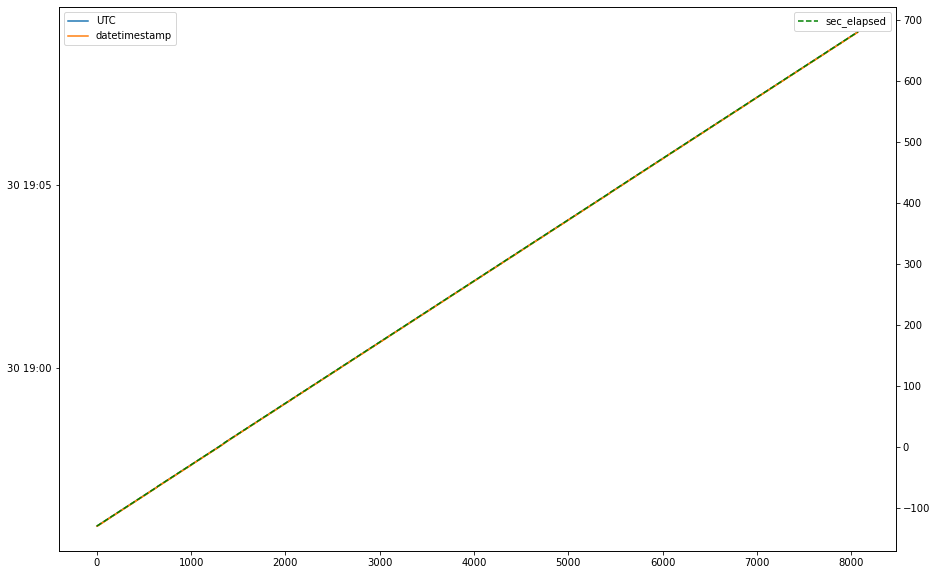

In [55]:
#df = pd.read_csv(out_csv_dir+"/FLY460_processed.csv")
df = pd.read_csv(out_csv_dir+"/FLY458_processed.csv")
df = df.assign(UTC = pd.to_datetime(df.UTC))
df = df.assign(datetimestamp = pd.to_datetime(df.datetimestamp))

print(df.columns)

fig = plt.figure(figsize=(15,10))
plt.plot(df.UTC, label="UTC")
plt.plot(df.datetimestamp, label="datetimestamp")

ax = plt.gca()
ax2 = ax.twinx()
ax2.plot(df.sec_elapsed, 'g--', label="sec_elapsed")

ax.legend()
ax2.legend()

plt.show()

[0.1   0.1   0.1   ... 0.101 0.1   0.1  ]


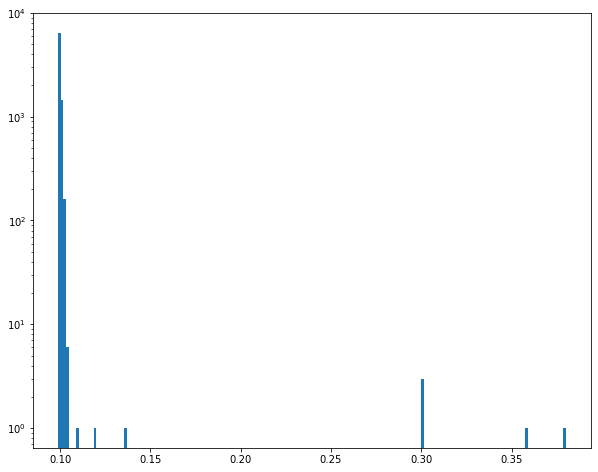

In [64]:
print(np.diff(df.sec_elapsed))
fig = plt.figure(figsize=(10, 8))
plt.hist(np.diff(df.sec_elapsed)[:-1], bins=200)
#plt.hist(np.diff(df.index)[:-1], bins=200)
plt.yscale("log")
plt.show()